In [1]:
import pandas as pd

In [4]:
df=pd.read_excel('../data/Consolidated Sales.xlsx', sheet_name='Main')

In [5]:
df.head(1)

,Material,Billing Doc.,Item,SALES OFFICE CODE,EXT MAT GROUP,MatGroup3,Star Rating,Segment,Star Rating.1,Stor. Location,...,SH CITY,SH POCODE,SH STATE,State Zone,Sales Person Name,Deal/Cust,Application Name,Billing,Inter/Intra,Period
0,FTL28TV16X2,1.933500e+09,230.0,MAA,RA-IDU,RA,N3S,Non Inv,3 Star,1010,...,CHENNAI.,602107,Tamilnadu,South,Ashok Kumar NC,4042,-,Branch Billing,Intrastate,Season


In [13]:
cols = ['Star Rating.1', 
        'Year', 
        'Month', 
        'Week', 
        'Billing Date', 
        'Billing Quantity ODU', 
        'Billing Quantity IDU', 
        'Tonnage',
        'Location',
        ]
df_subset = df
df_subset = df_subset[(df_subset['Billing Quantity ODU'] >= 0) & 
(df_subset['Billing Quantity IDU'] >= 0) & 
(df_subset['State Zone'] == 'South') &
(df_subset['Location'].isin(['Chennai', 'Secunderabad', 'Cochin', 'Bangalore', 'Vijaywada', 'Sricity']))
].reset_index(drop=True)
df_subset = df_subset[cols]

In [14]:
# Create a copy for standardization
df_standardized = df_subset.copy()

# 1. Rename Star Rating.1 to Star Rating (remove the .1 suffix)
df_standardized = df_standardized.rename(columns={'Star Rating.1': 'Star Rating'})

# 2. Parse and standardize Year format
def parse_year(year_str):
    """Parse year format like '19-20', '20-21' to proper year"""
    if pd.isna(year_str):
        return None
    
    year_str = str(year_str).strip()
    
    # Handle special case for '24-25 Q1'
    if 'Q1' in year_str:
        return 2024  # Assuming Q1 refers to 2024
    
    # Handle format like '19-20', '20-21'
    if '-' in year_str:
        parts = year_str.split('-')
        if len(parts) == 2:
            first_part = parts[0].strip()
            if len(first_part) == 2:
                # Convert 2-digit year to 4-digit
                year = int('20' + first_part)
                return year
    
    # Try to convert directly if it's already a 4-digit year
    try:
        return int(year_str)
    except:
        return None

df_standardized['YYYY'] = df_standardized['Year'].apply(parse_year)
df_standardized = df_standardized.drop(columns=['Year'])


def parse_month(month_str):
    """Parse month format like '12) Mar', '11) Feb' to numeric 1-12"""
    if pd.isna(month_str):
        return None
    
    month_str = str(month_str).strip()
    
    # Extract number from format like '12) Mar'
    if ')' in month_str:
        number_part = month_str.split(')')[0].strip()
        try:
            return int(number_part)
        except:
            return None
    
    # Try direct conversion
    try:
        return int(month_str)
    except:
        return None

df_standardized['Month'] = df_standardized['Month'].apply(parse_month)


def parse_week(week_str):
    """Parse week format like 'Wk 4', 'Wk 3' to numeric 1-4"""
    if pd.isna(week_str):
        return None
    
    week_str = str(week_str).strip()
    
    # Extract number from format like 'Wk 4'
    if 'Wk' in week_str:
        number_part = week_str.replace('Wk', '').strip()
        try:
            return int(number_part)
        except:
            return None
    
    # Try direct conversion
    try:
        return int(week_str)
    except:
        return None

df_standardized['Week'] = df_standardized['Week'].apply(parse_week)

# 5. Create continuous month and week columns
# Sort by YYYY, Month, Week to ensure proper ordering
df_standardized = df_standardized.sort_values(['YYYY', 'Month', 'Week']).reset_index(drop=True)

# 6. Create QTY column by combining Billing Quantity ODU + Billing Quantity IDU
df_standardized['QTY'] = df_standardized['Billing Quantity ODU'] + df_standardized['Billing Quantity IDU']

# df_standardized['Category'] = df_standardized['Tonnage'].astype(str) + '_' + df_standardized['Location'] + '_' + df_standardized['Star Rating'].astype(str)

# 7. Remove redundant columns
columns_to_remove = ['Billing Quantity ODU', 'Billing Quantity IDU', 'Tonnage', 'Star Rating']
df_standardized = df_standardized.drop(columns=columns_to_remove)


In [15]:
df_standardized

,Month,Week,Billing Date,Location,YYYY,QTY
0,1,1,2019-04-06,Chennai,2019,1.0
1,1,1,2019-04-06,Chennai,2019,1.0
2,1,1,2019-04-06,Cochin,2019,1.0
3,1,1,2019-04-06,Cochin,2019,1.0
4,1,1,2019-04-06,Cochin,2019,2.0
...,...,...,...,...,...,...
287418,12,4,2024-03-22,Secunderabad,2023,3.0
287419,12,4,2024-03-22,Sricity,2023,40.0
287420,12,4,2024-03-22,Sricity,2023,40.0
287421,12,4,2024-03-22,Sricity,2023,20.0


In [17]:
# df_standardized = df_standardized.dropna(subset=['Category'])
key_columns = ['YYYY', 'Month', 'Week', 'Month_Continuous', 'Week_Continuous', 'QTY', 'Location']
for col in key_columns:
    if col in df_standardized.columns:
        missing_count = df_standardized[col].isnull().sum()
        print(f"{col}: {missing_count} missing values")



YYYY: 0 missing values
Month: 0 missing values
Week: 0 missing values
QTY: 0 missing values
Location: 0 missing values


In [18]:
start_date = df_standardized['Billing Date'].min()
end_date = df_standardized['Billing Date'].max()
total_sales = df_standardized['QTY'].sum()
print(f"Total number of Sales in from {start_date} to {end_date} is {total_sales:,.2f}")

Total number of Sales in from 2019-04-03 00:00:00 to 2024-03-31 00:00:00 is 2,224,597.00


In [19]:
df_standardized.head()

,Month,Week,Billing Date,Location,YYYY,QTY
0,1,1,2019-04-06,Chennai,2019,1.0
1,1,1,2019-04-06,Chennai,2019,1.0
2,1,1,2019-04-06,Cochin,2019,1.0
3,1,1,2019-04-06,Cochin,2019,1.0
4,1,1,2019-04-06,Cochin,2019,2.0


In [34]:
monthly_sales = df_standardized.groupby(pd.Grouper(key='Billing Date', freq='MS'))['QTY'].sum().reset_index()
monthly_sales.head()

,Billing Date,QTY
0,2019-04-01,49432.0
1,2019-05-01,62585.0
2,2019-06-01,26843.0
3,2019-07-01,18577.0
4,2019-08-01,19794.0


In [35]:
monthly_sales.describe().T

,count,mean,min,25%,50%,75%,max,std
Billing Date,60,2021-09-15 14:00:00,2019-04-01 00:00:00,2020-06-23 12:00:00,2021-09-16 00:00:00,2022-12-08 18:00:00,2024-03-01 00:00:00,NaN
QTY,60.0,37076.616667,0.0,19861.5,29276.5,43277.5,148198.0,24713.55634


In [39]:
Q1 = monthly_sales['QTY'].quantile(0.25)
Q3 = monthly_sales['QTY'].quantile(0.75)
IQR = Q3 - Q1

outliers = monthly_sales[(monthly_sales['QTY'] < Q1 - 1.5 * IQR) | (monthly_sales['QTY'] > Q3 + 1.5 * IQR)]
print(outliers)


   Billing Date       QTY
56   2023-12-01   93044.0
58   2024-02-01   78938.0
59   2024-03-01  148198.0


In [42]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(monthly_sales['QTY']))
outliers = monthly_sales[z_scores > 3]  # Threshold = 3
print(outliers)


   Billing Date       QTY
59   2024-03-01  148198.0


In [43]:
rolling_mean = monthly_sales['QTY'].rolling(window=3).mean()
rolling_std = monthly_sales['QTY'].rolling(window=3).std()

outliers = monthly_sales[np.abs(monthly_sales['QTY'] - rolling_mean) > 2 * rolling_std]
print(outliers)


Empty DataFrame
Columns: [Billing Date, QTY]
Index: []


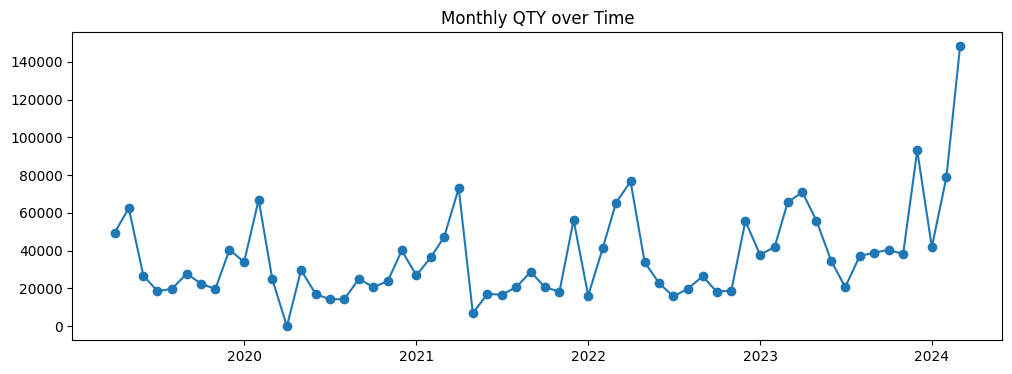

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(monthly_sales['Billing Date'], monthly_sales['QTY'], marker='o')
plt.title('Monthly QTY over Time')
plt.show()


In [100]:
from nixtla import NixtlaClient

In [101]:
API_KEY = "nixak-BPWuiu0QLaDocnyGH7oFOutH821mnpHI5jFwgujKGyPGiLCAqNkQGUQ0vp11ZSOXX9msKcsCZgVM8cRu"

nixtla_client = NixtlaClient(api_key = API_KEY)

In [107]:
monthly_sales.head()

,Billing Date,QTY
0,2019-04-01,49432.0
1,2019-05-01,62585.0
2,2019-06-01,26843.0
3,2019-07-01,18577.0
4,2019-08-01,19794.0


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


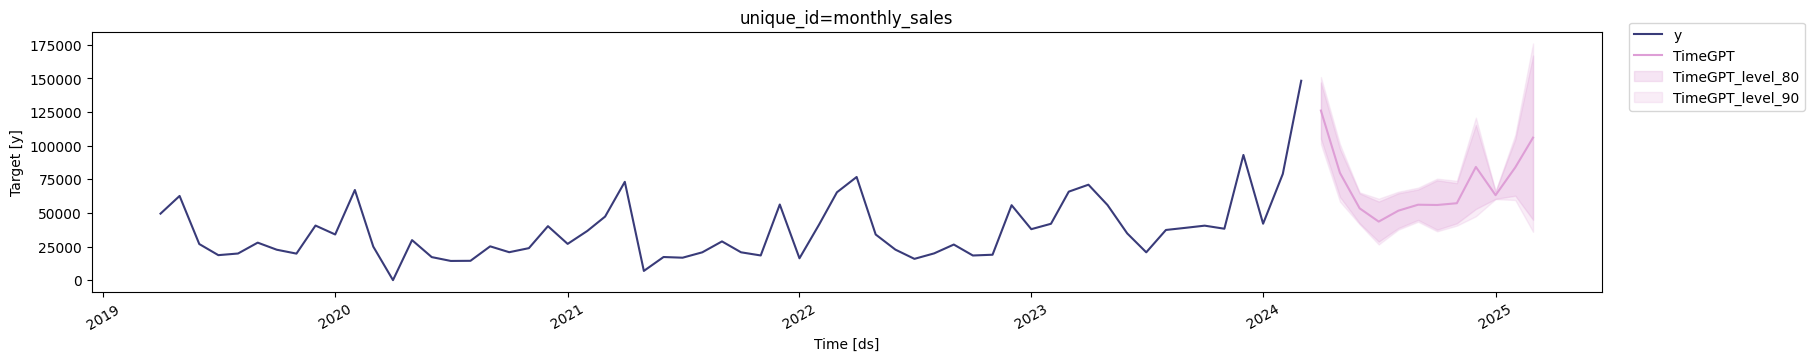

In [109]:
# 3. Forecast the next 24 hours
test = pd.DataFrame()
test['ds'] = pd.to_datetime(monthly_sales['Billing Date'])
test['y'] = monthly_sales['QTY']
test['unique_id'] = 'monthly_sales'
fcst_df = nixtla_client.forecast(test, h=12, level=[80, 90])

# 4. Plot your results (optional)
nixtla_client.plot(test, fcst_df, level=[80, 90])


In [35]:
# Group df_standardized by Yearly, Month, and Location
grouped_sales = df_standardized.groupby(['YYYY', 'Month', 'Location']).agg({
    'QTY': ['sum', 'mean', 'count'],
    'Billing Date': ['min', 'max']
}).reset_index()

# Flatten column names
grouped_sales.columns = ['YYYY', 'Month', 'Location', 'QTY_sum', 'QTY_mean', 'QTY_count', 'Billing_Date_min', 'Billing_Date_max']

print("Grouped Sales Data:")
print(f"Shape: {grouped_sales.shape}")
print(grouped_sales.head())


Grouped Sales Data:
Shape: (286, 8)
   YYYY  Month      Location  QTY_sum   QTY_mean  QTY_count Billing_Date_min  \
0  2019      1     Bangalore   3951.0   5.382834        734       2019-04-03   
1  2019      1       Chennai  24969.0   7.538949       3312       2019-04-03   
2  2019      1        Cochin   3218.0   4.597143        700       2019-04-04   
3  2019      1  Secunderabad  17294.0  10.481212       1650       2019-04-03   
4  2019      2     Bangalore   4709.0   7.038864        669       2019-05-01   

  Billing_Date_max  
0       2019-04-30  
1       2019-04-30  
2       2019-04-30  
3       2019-04-30  
4       2019-05-31  


In [ ]:
# Load the weather data
weather_df = pd.read_csv('../outputs/processed_weather_data/all_locations_monthly_stats.csv')

# Convert month column to datetime and extract year and month
weather_df['month'] = pd.to_datetime(weather_df['month'])
weather_df['YYYY'] = weather_df['month'].dt.year
weather_df['Month'] = weather_df['month'].dt.month

print("Weather Data:")
print(f"Shape: {weather_df.shape}")
print(weather_df.head())
print(f"\nWeather columns: {weather_df.columns.tolist()}")
print(f"\nUnique locations in weather data: {weather_df['Location'].unique()}")
print(f"Unique locations in sales data: {grouped_sales['Location'].unique()}")


Weather Data (converted to financial year):
Shape: (456, 42)
       month             time_min             time_max  \
0 2019-04-01  2019-04-01 00:00:00  2019-04-30 23:00:00   
1 2019-05-01  2019-05-01 00:00:00  2019-05-31 23:00:00   
2 2019-06-01  2019-06-01 00:00:00  2019-06-30 23:00:00   
3 2019-07-01  2019-07-01 00:00:00  2019-07-31 23:00:00   
4 2019-08-01  2019-08-01 00:00:00  2019-08-31 23:00:00   

                       time_mean  temp_min  temp_max  temp_mean  dwpt_min  \
0  2019-04-15 23:30:00.000000000      26.0      40.0  31.565694      18.9   
1  2019-05-16 11:30:00.000000000      27.8      42.0  33.247446      14.4   
2  2019-06-15 23:30:00.000000000      25.0      42.6  33.402222      17.6   
3  2019-07-16 11:30:00.000000000      24.0      40.0  31.302016      18.8   
4  2019-08-16 11:30:00.000000000      24.6      39.0  30.914919      19.8   

   dwpt_max  dwpt_mean  ...  tsun_max  tsun_mean  coco_min  coco_max  \
0      29.0  25.010278  ...       NaN        NaN       

In [37]:
# Join the grouped sales data with weather data based on Location and Month
merged_df = grouped_sales.merge(
    weather_df, 
    on=['YYYY', 'Month', 'Location'], 
    how='left'
)

print("Merged Data:")
print(f"Shape: {merged_df.shape}")
print(f"Columns: {merged_df.columns.tolist()}")
print("\nFirst few rows:")
print(merged_df.head())

# Check for missing values in the merged data
print(f"\nMissing values in merged data:")
print(merged_df.isnull().sum())

# Check the overlap between sales and weather data
print(f"\nData overlap analysis:")
print(f"Sales data records: {len(grouped_sales)}")
print(f"Weather data records: {len(weather_df)}")
print(f"Merged data records: {len(merged_df)}")
print(f"Records with weather data: {len(merged_df.dropna(subset=['temp_mean']))}")


Merged Data:
Shape: (286, 47)
Columns: ['YYYY', 'Month', 'Location', 'QTY_sum', 'QTY_mean', 'QTY_count', 'Billing_Date_min', 'Billing_Date_max', 'month', 'time_min', 'time_max', 'time_mean', 'temp_min', 'temp_max', 'temp_mean', 'dwpt_min', 'dwpt_max', 'dwpt_mean', 'rhum_min', 'rhum_max', 'rhum_mean', 'prcp_min', 'prcp_max', 'prcp_mean', 'snow_min', 'snow_max', 'snow_mean', 'wdir_min', 'wdir_max', 'wdir_mean', 'wspd_min', 'wspd_max', 'wspd_mean', 'wpgt_min', 'wpgt_max', 'wpgt_mean', 'pres_min', 'pres_max', 'pres_mean', 'tsun_min', 'tsun_max', 'tsun_mean', 'coco_min', 'coco_max', 'coco_mean', 'calendar_year', 'calendar_month']

First few rows:
   YYYY  Month      Location  QTY_sum   QTY_mean  QTY_count Billing_Date_min  \
0  2019      1     Bangalore   3951.0   5.382834        734       2019-04-03   
1  2019      1       Chennai  24969.0   7.538949       3312       2019-04-03   
2  2019      1        Cochin   3218.0   4.597143        700       2019-04-04   
3  2019      1  Secunderabad  

In [38]:
# Display summary statistics of the merged data
print("Summary of Merged Data:")
print("="*50)

# Sales summary by location
print("\nSales Summary by Location:")
sales_by_location = merged_df.groupby('Location')['QTY_sum'].agg(['sum', 'mean', 'count']).round(2)
print(sales_by_location)

# Weather summary by location
print("\nWeather Summary by Location:")
weather_summary = merged_df.groupby('Location')[['temp_mean', 'rhum_mean', 'wspd_mean']].mean().round(2)
print(weather_summary)

# Check data availability by year and location
print("\nData Availability by Year and Location:")
availability = merged_df.groupby(['YYYY', 'Location']).size().unstack(fill_value=0)
print(availability)

# Show sample of merged data with key columns
print("\nSample of Merged Data (key columns):")
key_columns = ['YYYY', 'Month', 'Location', 'QTY_sum', 'temp_mean', 'rhum_mean', 'wspd_mean']
merged_df[key_columns].head(10)


Summary of Merged Data:

Sales Summary by Location:
                   sum      mean  count
Location                               
Bangalore     225400.0   3820.34     59
Chennai       783895.0  13286.36     59
Cochin        219571.0   3721.54     59
Secunderabad  652811.0  11064.59     59
Sricity       118356.0  14794.50      8
Vijaywada     224564.0   5346.76     42

Weather Summary by Location:
              temp_mean  rhum_mean  wspd_mean
Location                                     
Bangalore         23.64      73.17      12.92
Chennai           29.12      74.94       9.85
Cochin            27.55      80.93       7.31
Secunderabad      25.90      70.02      11.69
Sricity           26.87      74.73       9.87
Vijaywada         28.10      74.56       6.96

Data Availability by Year and Location:
Location  Bangalore  Chennai  Cochin  Secunderabad  Sricity  Vijaywada
YYYY                                                                  
2019             12       12      12           

,YYYY,Month,Location,QTY_sum,temp_mean,rhum_mean,wspd_mean
0,2019,1,Bangalore,3951.0,27.991643,49.857939,10.715181
1,2019,1,Chennai,24969.0,31.565694,70.098611,12.295556
2,2019,1,Cochin,3218.0,NaN,NaN,NaN
3,2019,1,Secunderabad,17294.0,30.852273,47.340909,11.066903
4,2019,2,Bangalore,4709.0,27.343284,68.128901,12.634783
5,2019,2,Chennai,23705.0,33.247446,66.135753,14.206452
6,2019,2,Cochin,2651.0,NaN,NaN,NaN
7,2019,2,Secunderabad,31520.0,33.434286,38.531429,12.049429
8,2019,3,Bangalore,2418.0,25.694986,78.798050,19.437744
9,2019,3,Chennai,12397.0,33.402222,59.909722,13.555833


In [45]:
merged_df['Location'].unique()

array(['Bangalore', 'Chennai', 'Cochin', 'Secunderabad', 'Vijaywada',
       'Sricity'], dtype=object)

In [54]:
merged_df

,YYYY,Month,Location,QTY_sum,QTY_mean,QTY_count,Billing_Date_min,Billing_Date_max,month,time_min,...,pres_max,pres_mean,tsun_min,tsun_max,tsun_mean,coco_min,coco_max,coco_mean,calendar_year,calendar_month
0,2019,1,Bangalore,3951.0,5.382834,734,2019-04-03,2019-04-30,2019-04-01,2019-04-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,4.0
1,2019,1,Chennai,24969.0,7.538949,3312,2019-04-03,2019-04-30,2019-04-01,2019-04-01 00:00:00,...,1015.1,1008.938056,NaN,NaN,NaN,0.0,18.0,2.565278,2019.0,4.0
2,2019,1,Cochin,3218.0,4.597143,700,2019-04-04,2019-04-30,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019,1,Secunderabad,17294.0,10.481212,1650,2019-04-03,2019-04-30,2019-04-01,2019-04-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,4.0
4,2019,2,Bangalore,4709.0,7.038864,669,2019-05-01,2019-05-31,2019-05-01,2019-05-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,2023,12,Bangalore,12393.0,9.269260,1337,2024-03-04,2024-03-30,2024-03-01,2024-03-01 00:00:00,...,1021.0,1015.869892,NaN,NaN,NaN,1.0,5.0,1.961022,2024.0,3.0
282,2023,12,Chennai,23825.0,7.078134,3366,2024-03-01,2024-03-31,2024-03-01,2024-03-01 00:00:00,...,1016.6,1011.903763,NaN,NaN,NaN,1.0,5.0,2.470430,2024.0,3.0
283,2023,12,Cochin,15967.0,7.378466,2164,2024-03-04,2024-03-30,2024-03-01,2024-03-01 00:00:00,...,1016.0,1011.004973,NaN,NaN,NaN,1.0,18.0,4.619624,2024.0,3.0
284,2023,12,Secunderabad,41295.0,12.953262,3188,2024-03-01,2024-03-31,2024-03-01,2024-03-01 00:00:00,...,1020.0,1014.307124,NaN,NaN,NaN,1.0,17.0,2.364247,2024.0,3.0


In [66]:
# Handle missing weather data by calculating monthly averages from other years
print("Handling Missing Weather Data:")
print("="*50)

# Identify weather-related columns
weather_columns = [col for col in merged_df.columns if any(weather_feature in col for weather_feature in 
                   ['temp_', 'rhum_', 'wspd_', 'pres_', 'prcp_', 'wdir_', 'dwpt_', 'tsun_', 'coco_', 'wpgt_', 'snow_'])]

print(f"Weather columns to process: {weather_columns}")

# Create a copy to work with
merged_df_filled = merged_df.copy()

# Function to fill missing values with monthly averages from other years
def fill_missing_weather_data(df, location, month, weather_cols):
    """
    Fill missing weather data for a specific location and month using averages from other years
    """
    # Get data for this location and month from other years
    other_years_data = df[(df['Location'] == location) & (df['Month'] == month) & (df[weather_cols].notna().any(axis=1))]
    
    if len(other_years_data) > 0:
        # Calculate mean for each weather column
        monthly_averages = other_years_data[weather_cols].mean()
        return monthly_averages
    else:
        # If no data available for this month, use overall location average
        location_data = df[(df['Location'] == location) & (df[weather_cols].notna().any(axis=1))]
        if len(location_data) > 0:
            return location_data[weather_cols].mean()
        else:
            # If no data for location, use overall average
            return df[weather_cols].mean()

# Apply the filling logic
print("\nFilling missing weather data...")
for location in merged_df_filled['Location'].unique():
    for month in merged_df_filled['Month'].unique():
        # Find rows with missing weather data for this location and month
        mask = (merged_df_filled['Location'] == location) & (merged_df_filled['Month'] == month)
        missing_mask = mask & merged_df_filled[weather_columns].isna().any(axis=1)
        
        if missing_mask.any():
            print(f"Filling missing data for {location}, Month {month}")
            # Get monthly averages from other years
            monthly_averages = fill_missing_weather_data(merged_df_filled, location, month, weather_columns)
            
            # Fill the missing values
            for col in weather_columns:
                if not pd.isna(monthly_averages[col]):
                    merged_df_filled.loc[missing_mask, col] = monthly_averages[col]

print("\nMissing data handling completed!")


Handling Missing Weather Data:
Weather columns to process: ['temp_min', 'temp_max', 'temp_mean', 'dwpt_min', 'dwpt_max', 'dwpt_mean', 'rhum_min', 'rhum_max', 'rhum_mean', 'prcp_min', 'prcp_max', 'prcp_mean', 'snow_min', 'snow_max', 'snow_mean', 'wdir_min', 'wdir_max', 'wdir_mean', 'wspd_min', 'wspd_max', 'wspd_mean', 'wpgt_min', 'wpgt_max', 'wpgt_mean', 'pres_min', 'pres_max', 'pres_mean', 'tsun_min', 'tsun_max', 'tsun_mean', 'coco_min', 'coco_max', 'coco_mean']

Filling missing weather data...
Filling missing data for Bangalore, Month 1
Filling missing data for Bangalore, Month 2
Filling missing data for Bangalore, Month 3
Filling missing data for Bangalore, Month 4
Filling missing data for Bangalore, Month 5
Filling missing data for Bangalore, Month 6
Filling missing data for Bangalore, Month 7
Filling missing data for Bangalore, Month 8
Filling missing data for Bangalore, Month 9
Filling missing data for Bangalore, Month 10
Filling missing data for Bangalore, Month 11
Filling missin

In [67]:
# Compare before and after filling missing data
print("Missing Data Analysis:")
print("="*50)

print("BEFORE filling missing data:")
print(f"Total missing values: {merged_df[weather_columns].isnull().sum().sum()}")
print(f"Missing values by column:")
missing_before = merged_df[weather_columns].isnull().sum()
print(missing_before[missing_before > 0])

print("\nAFTER filling missing data:")
print(f"Total missing values: {merged_df_filled[weather_columns].isnull().sum().sum()}")
print(f"Missing values by column:")
missing_after = merged_df_filled[weather_columns].isnull().sum()
print(missing_after[missing_after > 0])

# Show improvement
print(f"\nImprovement:")
print(f"Missing values reduced by: {missing_before.sum() - missing_after.sum()}")
print(f"Percentage of missing data filled: {((missing_before.sum() - missing_after.sum()) / missing_before.sum() * 100):.1f}%")


Missing Data Analysis:
BEFORE filling missing data:
Total missing values: 3171
Missing values by column:
temp_min       9
temp_max       9
temp_mean      9
dwpt_min       9
dwpt_max       9
dwpt_mean      9
rhum_min       9
rhum_max       9
rhum_mean      9
prcp_min     100
prcp_max     100
prcp_mean    100
snow_min     286
snow_max     286
snow_mean    286
wdir_min       9
wdir_max       9
wdir_mean      9
wspd_min       9
wspd_max       9
wspd_mean      9
wpgt_min     286
wpgt_max     286
wpgt_mean    286
pres_min      27
pres_max      27
pres_mean     27
tsun_min     286
tsun_max     286
tsun_mean    286
coco_min      27
coco_max      27
coco_mean     27
dtype: int64

AFTER filling missing data:
Total missing values: 2574
Missing values by column:
snow_min     286
snow_max     286
snow_mean    286
wpgt_min     286
wpgt_max     286
wpgt_mean    286
tsun_min     286
tsun_max     286
tsun_mean    286
dtype: int64

Improvement:
Missing values reduced by: 597
Percentage of missing data f

In [68]:
# Show sample of filled data
print("Sample of Filled Data:")
print("="*50)

# Show a few examples of filled data
sample_locations = ['Bangalore', 'Chennai', 'Cochin']
for location in sample_locations:
    print(f"\n{location} - Sample data:")
    location_data = merged_df_filled[merged_df_filled['Location'] == location][['YYYY', 'Month', 'Location', 'QTY_sum', 'temp_mean', 'rhum_mean', 'wspd_mean']].head(5)
    print(location_data)

# Final summary of the filled dataset
print(f"\nFinal Dataset Summary:")
print(f"Shape: {merged_df_filled.shape}")
print(f"Complete weather data records: {len(merged_df_filled.dropna(subset=['temp_mean']))}")
print(f"Data completeness: {(len(merged_df_filled.dropna(subset=['temp_mean'])) / len(merged_df_filled) * 100):.1f}%")

# Save the filled dataset
merged_df_filled.to_csv('../outputs/data/sales_weather_merged_filled.csv', index=False)
print(f"\nFilled dataset saved to: ../outputs/data/sales_weather_merged_filled.csv")


Sample of Filled Data:

Bangalore - Sample data:
    YYYY  Month   Location  QTY_sum  temp_mean  rhum_mean  wspd_mean
0   2019      1  Bangalore   3951.0  27.041071  54.193651  10.347719
4   2019      2  Bangalore   4709.0  26.270377  69.900511  13.101580
8   2019      3  Bangalore   2418.0  24.810296  76.857086  17.832391
12  2019      4  Bangalore   2252.0  23.654283  82.423583  18.792103
16  2019      5  Bangalore   1565.0  23.694694  81.331796  17.527513

Chennai - Sample data:
    YYYY  Month Location  QTY_sum  temp_mean  rhum_mean  wspd_mean
1   2019      1  Chennai  24969.0  30.982535  72.660069  11.148819
5   2019      2  Chennai  23705.0  32.056290  69.743659  12.313199
9   2019      3  Chennai  12397.0  32.131806  66.377500  12.700583
13  2019      4  Chennai   8889.0  30.416935  72.369892  11.198172
17  2019      5  Chennai   9185.0  30.300430  73.182527  10.861478

Cochin - Sample data:
    YYYY  Month Location  QTY_sum  temp_mean  rhum_mean  wspd_mean
2   2019      1   Coc

In [69]:
merged_df_filled.columns

Index(['YYYY', 'Month', 'Location', 'QTY_sum', 'QTY_mean', 'QTY_count',
       'Billing_Date_min', 'Billing_Date_max', 'month', 'time_min', 'time_max',
       'time_mean', 'temp_min', 'temp_max', 'temp_mean', 'dwpt_min',
       'dwpt_max', 'dwpt_mean', 'rhum_min', 'rhum_max', 'rhum_mean',
       'prcp_min', 'prcp_max', 'prcp_mean', 'snow_min', 'snow_max',
       'snow_mean', 'wdir_min', 'wdir_max', 'wdir_mean', 'wspd_min',
       'wspd_max', 'wspd_mean', 'wpgt_min', 'wpgt_max', 'wpgt_mean',
       'pres_min', 'pres_max', 'pres_mean', 'tsun_min', 'tsun_max',
       'tsun_mean', 'coco_min', 'coco_max', 'coco_mean', 'calendar_year',
       'calendar_month'],
      dtype='object')

In [81]:
merged_df_filled_consolidated = merged_df_filled.drop(columns=[
                               'QTY_mean', 
                               'QTY_count',
                               'Billing_Date_min',
                               'Billing_Date_max',
                               'month',
                               'time_min',
                               'time_max',
                               'snow_min',
                               'snow_max',
                               'snow_mean',
                               'wdir_min',
                               'wdir_max',
                               'wdir_mean',
                               'wpgt_min',
                               'wpgt_max',
                               'wpgt_mean',
                               'tsun_min',
                               'tsun_max',
                               'tsun_mean',
                               'pres_min',
                               'pres_max',
                               'pres_mean',
                               'coco_min',
                               'coco_max',
                               'coco_mean',
                               'tsun_min',
                               'tsun_max',
                               'tsun_mean',
                               'calendar_year',
                               'calendar_month',
                               ])

In [83]:
merged_df_filled_consolidated['actual_month'] = ((merged_df_filled_consolidated['Month'] + 3) % 12) + 1

# Adjust year: if fiscal month is Jan–Mar (Month 10–12 in fiscal terms), increment year
merged_df_filled_consolidated['actual_year'] = merged_df_filled_consolidated['YYYY'] + (merged_df_filled_consolidated['actual_month'] < 4).astype(int)

# Combine to datetime (use 1st of the month)
merged_df_filled_consolidated['date'] = pd.to_datetime(dict(year=merged_df_filled_consolidated['actual_year'], month=merged_df_filled_consolidated['actual_month'], day=1))

merged_df_filled_consolidated.drop(columns=['actual_month', 'actual_year', 'YYYY', 'Month', 'time_mean'], inplace=True)
merged_df_filled_consolidated.rename(columns={'QTY_sum': 'QTY'}, inplace=True)
merged_df_filled_consolidated.head().T


,0,1,2,3,4
Location,Bangalore,Chennai,Cochin,Secunderabad,Bangalore
QTY,3951.0,24969.0,3218.0,17294.0,4709.0
temp_min,19.0,25.1,23.0,20.75,19.6
temp_max,35.25,39.9,35.666667,39.75,34.4
temp_mean,27.041071,30.982535,28.519028,29.972061,26.270377
dwpt_min,0.775,17.8,19.233333,6.65,10.24
dwpt_max,23.275,28.825,27.966667,25.0,24.42
dwpt_mean,15.193029,25.123715,24.551019,17.374348,19.395948
rhum_min,12.25,32.5,45.0,12.0,24.8
rhum_max,100.0,95.75,100.0,98.5,100.0


In [84]:
merged_df_filled_consolidated.to_csv('../outputs/data/sales_weather_merged_filled_consolidated.csv', index=False)

In [ ]:
merged_df_filled_consolidated